In [5]:
import matplotlib.pyplot as pltimport
import xhermes as xh
from boutdata.data import BoutData
from boutdata import collect
import matplotlib.pyplot as plt
import glob     
import re
import numpy as np
import pandas as pd
from heatflux_functions import *
from data_accessors import *
import xarray as xr

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
linewidth = 3
markersize = 15


plt.style.use('ggplot')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams.update({'font.size': 14})


def replace_guards(var):
    """
	This in-place replaces the points in the guard cells with the points on the boundary
    
    """
    # Strip the edge guard cells
    var = var[1:-1]

    var[0] = 0.5*(var[0] + var[1])
    var[-1] = 0.5*(var[-1] + var[-2])
    return var

In [6]:
ds = pd.read_pickle('/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/flux_limit/Flux_limiter_detachment_ITER_final.pickle')

print(ds.keys())

Index(['Bxy', 'Ed+_iz', 'Ed+_rec', 'Ed_target_recycle', 'Edd+_cx', 'Fd+_iz',
       'Fd+_rec', 'Fdd+_cx', 'G1', 'G2', 'G3', 'J', 'NVd', 'NVd+', 'Nd', 'Nd+',
       'Ne', 'Pd', 'Pd+', 'Pd+_src', 'Pd_src', 'Pe', 'Pe_src', 'Rd+_ex',
       'Rd+_rec', 'Rneon', 'SNVd', 'SNVd+', 'SNd', 'SNd+', 'SPd', 'SPd+',
       'SPe', 'Sd+_feedback', 'Sd+_iz', 'Sd+_rec', 'Sd+_src', 'Sd_src',
       'Sd_target_recycle', 'Td', 'Td+', 'Te', 'Vd', 'Vd+', 'Ve', 'ddt(NVd)',
       'ddt(NVd+)', 'ddt(Nd)', 'ddt(Nd+)', 'ddt(Pd)', 'ddt(Pd+)', 'ddt(Pe)',
       'density_feedback_src_i_d+', 'density_feedback_src_mult_d+',
       'density_feedback_src_p_d+', 'density_feedback_src_shape_d+', 'g11',
       'g12', 'g13', 'g22', 'g23', 'g33', 'g_11', 'g_12', 'g_13', 'g_22',
       'g_23', 'g_33', 'kappa_par_d', 'kappa_par_d+', 'kappa_par_e', 't_array',
       'ncalls', 'ncalls_e', 'ncalls_i', 'target_temp', 'y', 'alpha',
       'neon_frac', 'Div_Q_SH', 'Div_Q_SNB'],
      dtype='object')


0      1.528220e+10
1      1.528206e+10
2      1.528162e+10
3      1.528104e+10
4      1.528032e+10
           ...     
793    6.572583e+07
794    4.489328e+07
795    2.944170e+07
796    1.817076e+07
797    1.415997e+07
Name: kappa_par_d+, Length: 798, dtype: float64


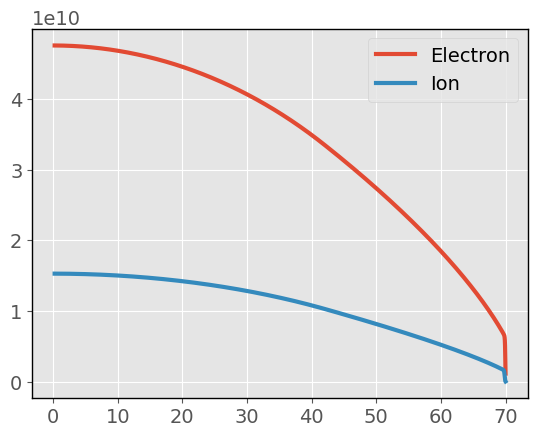

In [7]:
sh = ds[(ds['alpha'] == 'SH') & (ds['neon_frac'] == 0.0)]

y = sh['y']
kappa_e = sh['kappa_par_e'].dropna()
kappa_i = sh['kappa_par_d+'].dropna()
# kappa_e = kappa_e.dropna()

print(kappa_i)

plt.plot(y, kappa_e, label='Electron', linewidth=linewidth)
plt.plot(y, kappa_i, label='Ion', linewidth=linewidth)
plt.legend()

Comparison of electron heat flux calculated according to explicit SH conduction case (using the method described in BOUT++ documentation https://bout-dev.readthedocs.io/en/latest/user_docs/nonlocal.html) and by integrating the div_q output of the SNB case. 

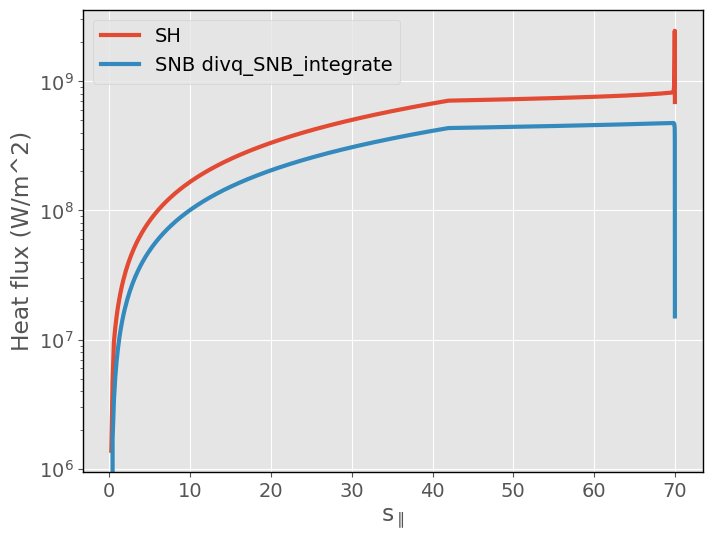

In [8]:
sh = ds[(ds['alpha'] == 'SH') & (ds['neon_frac'] == 0.0)]
snb = ds[(ds['alpha'] == 'SNB') & (ds['neon_frac'] == 0.0)]


x = sh['y']

q_electron = spitzer_q_electron(sh)
q_electron_simply = spitzer_q_electron_simple(sh)
q_electron_int_sh = divq_integrate(snb, False)
q_electron_int_snb = divq_integrate(snb, True)
q_electron_snb = spitzer_q_electron(snb)

fig,ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(x, q_electron, label='SH', linewidth=linewidth)
# ax.plot(x, q_electron_snb, label='SNB spitzer_q_electron (snb)', linewidth=linewidth)
# ax.plot(x, q_electron_simply, label='SH simple', linewidth=linewidth)
ax.plot(x, q_electron_int_snb, label='SNB divq_SNB_integrate', linewidth=linewidth)
# ax.plot(x, q_electron_int_sh, label='SNB divq_SH_integrate', linewidth=linewidth)
ax.set_yscale('log')
ax.set_ylabel('Heat flux (W/m^2)')
ax.set_xlabel(r's$_{\parallel}$')
ax.legend()

I then want to compare this to the input power that we inject upto the x-point, and check that the ion+electron spitzer heatflux adds to this

lambda_ei_ion 0      36.029217
1      36.028772
2      36.027461
3      36.025714
4      36.023600
         ...    
793     1.857249
794     1.717006
795     1.542435
796     1.339825
797     1.237922
Length: 798, dtype: float64


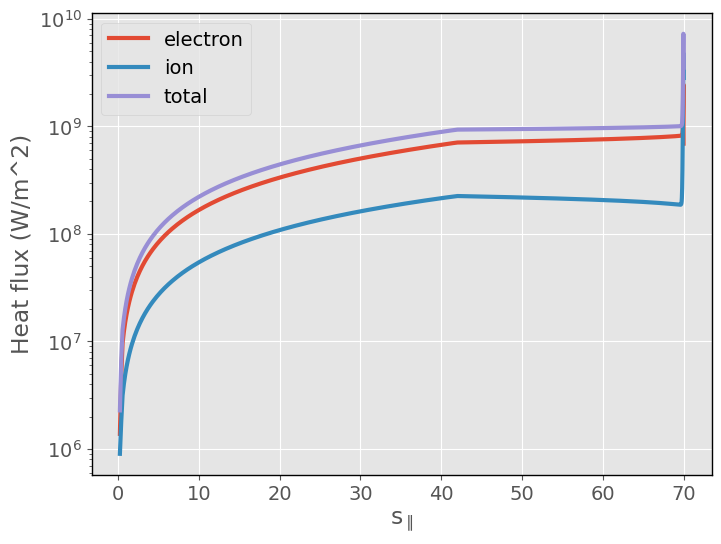

In [9]:
sh = ds[(ds['alpha'] == 'SH') & (ds['neon_frac'] == 0.0)]

x = sh['y']
q_electron = spitzer_q_electron(sh)
q_ion = spitzer_q_ion(sh)


q_total = q_electron + q_ion

fig,ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(x, q_electron, label='electron', linewidth=linewidth)
ax.plot(x, q_ion, label='ion', linewidth=linewidth)
ax.plot(x, q_total, label='total', linewidth=linewidth)
ax.set_yscale('log')
ax.set_ylabel('Heat flux (W/m^2)')
ax.set_xlabel(r's$_{\parallel}$')
ax.legend()

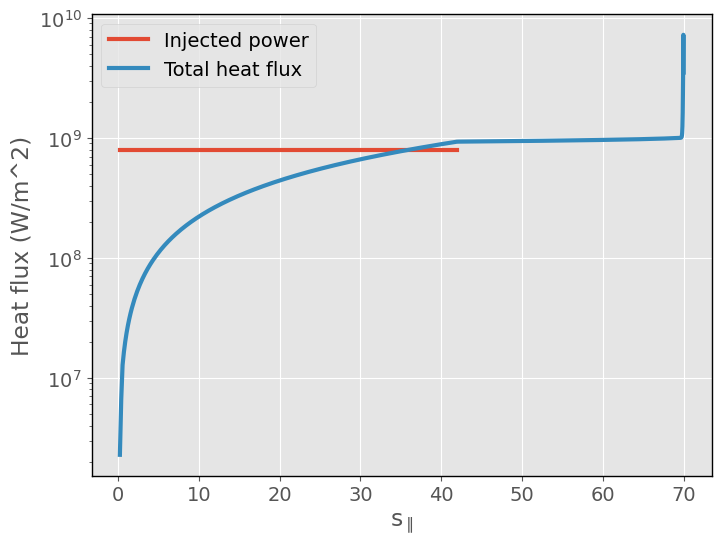

In [10]:
import numpy as np
x = sh['y']

x_point = 42
x_point_index = np.argmin(np.abs(x - x_point))


power_injection_electrons = np.array([4e8]*len(x[:x_point_index]))
power_injection_ions = np.array([4e8]*len(x[:x_point_index]))
power_injection_total = power_injection_electrons + power_injection_ions
power_injection_total = power_injection_total

fig,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(x[:x_point_index], power_injection_total, label='Injected power', linewidth=linewidth)
ax.plot(x, q_total, label='Total heat flux', linewidth=linewidth)
ax.set_yscale('log')
ax.set_ylabel('Heat flux (W/m^2)')
ax.set_xlabel(r's$_{\parallel}$')
ax.legend()


lambda_ei_ion 0      36.029217
1      36.028772
2      36.027461
3      36.025714
4      36.023600
         ...    
793     1.857249
794     1.717006
795     1.542435
796     1.339825
797     1.237922
Length: 798, dtype: float64


Text(0.5, 0, 's$_{\\parallel}$')

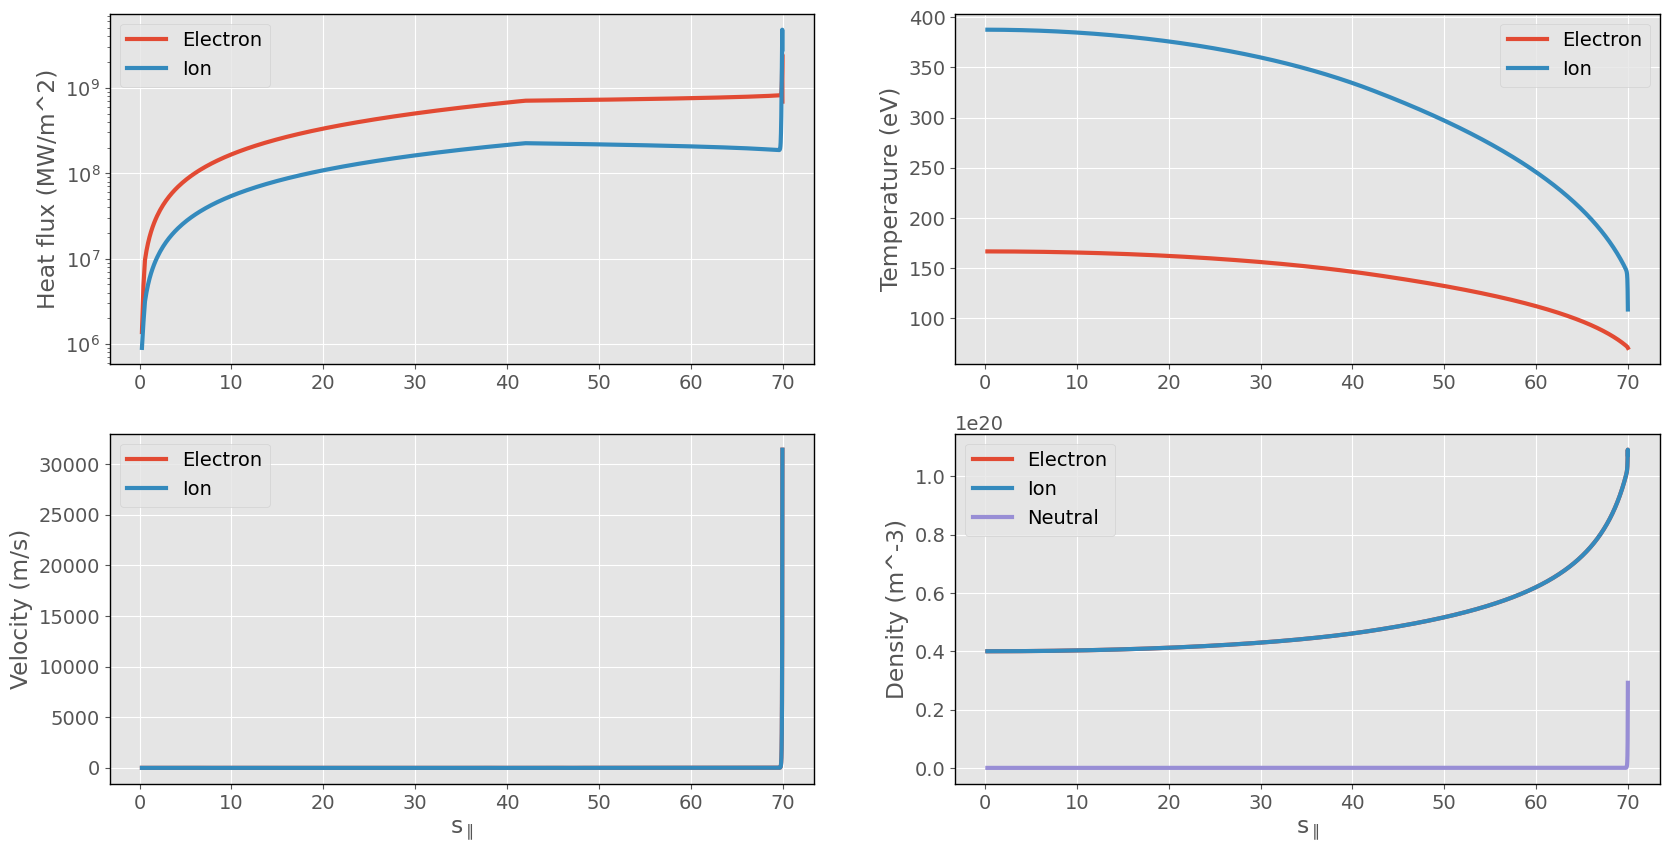

In [11]:
sh = ds[(ds['alpha'] == 'SH') & (ds['neon_frac'] == 0.0)]
x = sh['y']
q_electron = spitzer_q_electron(sh)
q_ion = spitzer_q_ion(sh)

fig,ax = plt.subplots(2,2, figsize=(20, 10))

ax[0,0].plot(x, q_electron, label='Electron', linewidth=linewidth)
# plt.yscale('log')
ax[0,0].plot(x, q_ion, label='Ion', linewidth=linewidth)
ax[0,0].set_ylabel('Heat flux (MW/m^2)')
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[0,1].plot(x, sh['Te'], label='Electron', linewidth=linewidth)
ax[0,1].plot(x, sh['Td+'], label='Ion', linewidth=linewidth)
ax[0,1].legend()
ax[0,1].set_ylabel('Temperature (eV)')

ax[1,0].plot(x, sh['Ve'], label='Electron', linewidth=linewidth)
ax[1,0].plot(x, sh['Vd+'], label='Ion', linewidth=linewidth)
ax[1,0].set_ylabel('Velocity (m/s)')
ax[1,0].legend()
ax[1,0].set_xlabel(r's$_{\parallel}$')


ax[1,1].plot(x, sh['Ne'], label='Electron', linewidth=linewidth)
ax[1,1].plot(x, sh['Nd+'], label='Ion', linewidth=linewidth)
ax[1,1].plot(x, sh['Nd'], label='Neutral', linewidth=linewidth)
ax[1,1].legend()
ax[1,1].set_ylabel('Density (m^-3)')
ax[1,1].set_xlabel(r's$_{\parallel}$')

0         -0.519024
1         -0.647140
2         -0.779643
3         -0.773379
4         -0.615890
           ...     
793     4265.479758
794     5821.101662
795     7982.715670
796    10782.091259
797    12656.456276
Length: 798, dtype: float64


(0.0, 10.0)

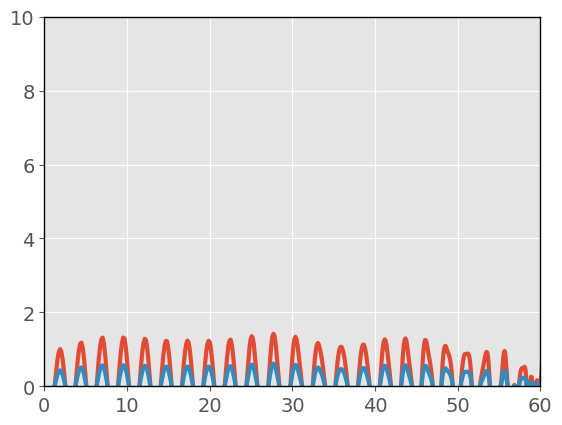

In [12]:
ion_conv = q_convective_ion(sh)
electron_conv = q_convective_electron(sh)

print(ion_conv)


plt.plot(x, ion_conv, label='Ion', linewidth=linewidth)
plt.plot(x, electron_conv, label='Electron', linewidth=linewidth)
plt.xlim(0,60)
plt.ylim(0,10)

# Testing SH ion flux models 

lambda_ei_ion 0      36.029217
1      36.028772
2      36.027461
3      36.025714
4      36.023600
         ...    
793     1.857249
794     1.717006
795     1.542435
796     1.339825
797     1.237922
Length: 798, dtype: float64
lambda_ei_ion 0      36.029217
1      36.028772
2      36.027461
3      36.025714
4      36.023600
         ...    
793     1.857249
794     1.717006
795     1.542435
796     1.339825
797     1.237922
Length: 798, dtype: float64


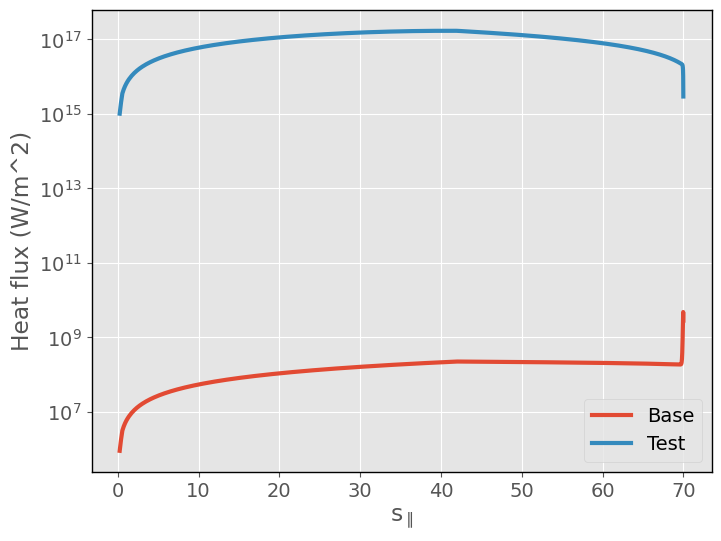

In [13]:
sh = ds[(ds['alpha'] == 'SH') & (ds['neon_frac'] == 0.0)]

x = sh['y']

q_ion_base = spitzer_q_ion(sh)

q_ion_test = test_spitzer_q_ion(sh)

q_ion_simple = spitzer_q_ion_simple(sh)

fig,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(x, q_ion_base, label='Base', linewidth=linewidth)
ax.plot(x, q_ion_test, label='Test', linewidth=linewidth)
# ax.plot(x, q_ion_simple, label='Simple', linewidth=linewidth)
ax.set_yscale('log')
ax.set_ylabel('Heat flux (W/m^2)')
ax.set_xlabel(r's$_{\parallel}$')
ax.legend()


Pretty clear that the ion thermal speed is important here... and that the way I'm currently doing it in spitzer_q_ion is correct... or at least more correct!

In [14]:
Te = sh['Te']
Ti = sh['Td+']

log_Ti = np.log(Ti)
log_Te = np.log(Te)

print('log_Ti', log_Ti)
print('log_Te', log_Te)

log_Ti 0      5.960199
1      5.960195
2      5.960183
3      5.960167
4      5.960147
         ...   
793    4.891336
794    4.856500
795    4.807416
796    4.737244
797    4.687921
Name: Td+, Length: 798, dtype: float64
log_Te 0      5.115313
1      5.115311
2      5.115301
3      5.115286
4      5.115268
         ...   
793    4.262891
794    4.260581
795    4.257705
796    4.254148
797    4.253257
Name: Te, Length: 798, dtype: float64


# Checking SH vs SNB for higher collisionalities, should trend to the same! 

In [15]:
SH_high_coll = xh.open('/shared/storage/plasmahwdisks/data/jlb647/simulation_data/flux_limiter_detachment/2023-12-15_wigram_reference_detached/old_detached').isel(t=-1)
snb_high_coll = xh.open('/shared/storage/plasmahwdisks/data/jlb647/simulation_data/flux_limiter_detachment/2023-12-15_wigram_reference_detached/old_detached_snb').isel(t=-1)

OSError: No datafiles found matching datapath=/shared/storage/plasmahwdisks/data/jlb647/simulation_data/flux_limiter_detachment/2023-12-15_wigram_reference_detached/old_detached/BOUT.dmp.*.nc

In [ ]:
# Constants
e = 1.602e-19  # Electron charge in Coulombs
m_e = 9.109e-31  # Electron mass in kg
pi = np.pi
k0 = 13.58  # Given constant
epsilon_0 = 8.85e-12  # Permittivity of free space in F/m
k_B = 1.38e-23  # Boltzmann constant, J/K

def spitzer_q_electron(dataset):
    Z = 1  # Average ion charge, example value
    x = np.ravel(dataset['y'].values)
    Te = np.ravel(dataset['Te'].values)
    Ne = np.ravel(dataset['Ne'].values)
    Ni = np.ravel(dataset['Nd+'].values)

    Y = 4 * pi * (e**2 / (4 * pi * epsilon_0 * m_e))**2
    ln_alpha = 6.6 - 0.5 * np.log(Ne / 1e20) + 1.5 * np.log(Te)
    v_t = np.sqrt(2 * e * Te / m_e)
    lambda_ei = (v_t**4) / (Y * Ni * ln_alpha)
    tau_t = lambda_ei / v_t
    grad_T = np.gradient(Te, x)  # Assuming x and Te are 1D arrays

    q = -((Ne * e * Te) / (m_e)) * ((3 * np.sqrt(pi)) / 4) * (tau_t * k0) * ((1 + 0.24) / (1 + 4.2)) * grad_T
    q_SH_electron = q * e  # Convert from ev/m^2/s to W/m^2

    return xr.DataArray(q_SH_electron, dims=["y"], coords={"y": x})


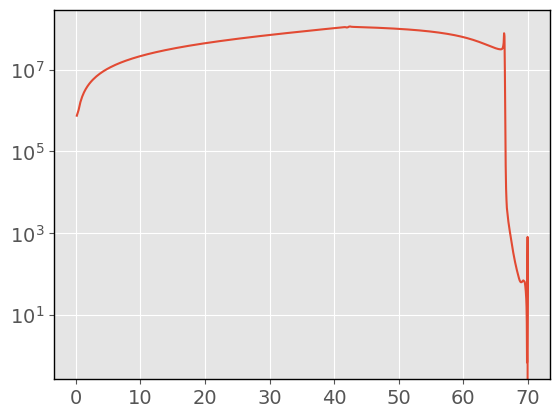

In [ ]:
Te = np.ravel(SH_high_coll['Te'].values)
y = np.ravel(SH_high_coll['y'].values)

q_electron = spitzer_q_electron(SH_high_coll)


# plt.plot(y, Te, label='SH')
plt.plot(y, q_electron, label='SH')
# SH_high_coll['Te'].plot()
plt.yscale('log')
# snb_high_coll['Te'].plot()


# same again but for /500MW_5x10(19) with 1% neon


In [ ]:

SH_higher_coll = xh.open('/shared/storage/plasmahwdisks/data/jlb647/simulation_data/flux_limiter_detachment/2023-12-15_wigram_reference_detached/500MW_5x10(19)').isel(t=-1)
snb_higher_coll = xh.open('/shared/storage/plasmahwdisks/data/jlb647/simulation_data/flux_limiter_detachment/2023-12-15_wigram_reference_detached/500MW_5x10(19)_snb').isel(t=-1)


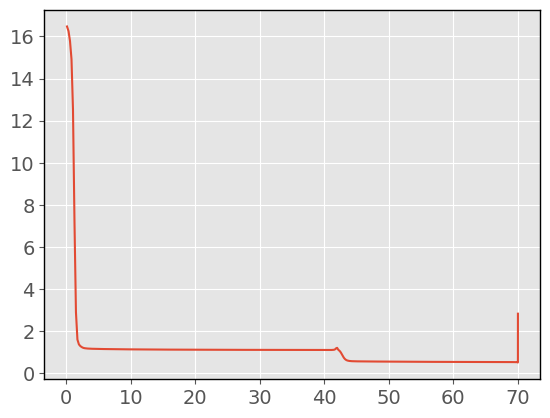

In [ ]:
Te = np.ravel(SH_higher_coll['Te'].values)
y = np.ravel(SH_higher_coll['y'].values)

plt.plot(y, Te, label='SH')